# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
import math
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-03-06 12:52:52.856964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-06 12:52:54.158016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 12:52:54.158128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-06 12:52:54.158137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop,0
1,"[""It won't be long before I'm leaving here"", ""...",pop,1
2,"['Are we crazy?', 'Living our lives through a ...",pop,2
3,"['When did it go wrong, I will never know', 'I...",pop,3
4,"[""I've waited all this time"", 'Counting minute...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  36000 non-null  object
 1   genre   36000 non-null  object
 2   id      36000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 843.9+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)

In [7]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']

In [8]:
df = df.drop(idxs_eval)
df = df.reset_index()

In [9]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

df_verse = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

#df_verse = df_verse.groupby('genre').sample(frac=0.05, random_state=42).reset_index()
#df_verse = df_verse.groupby('genre').sample(n=25, random_state=42).reset_index()
df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,My sweet love,pop,0,1
2,I miss you,pop,0,2
3,More than you'll ever know,pop,0,3
4,Goodbye my moonlight,pop,0,4
...,...,...,...,...
1828696,"And let the virgin conceive""",rock,35849,19
1828697,All the tales are told,rock,35849,20
1828698,All the orchids gone,rock,35849,21
1828699,Lost in my own world,rock,35849,22


In [10]:
#df_verse.groupby('lyrics_id').apply(lambda x: x.sample(n=2))

In [11]:
opening_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmin()]
final_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmax()]
middle_verse = df_verse.groupby('lyrics_id')['verse_id'].apply(
    lambda x: x.iloc[math.ceil(len(x)/2)-1]).reset_index()
middle_verse = pd.merge(df_verse, middle_verse, on=['lyrics_id', 'verse_id'])
df_verse = pd.concat([opening_verse, final_verse, middle_verse]).reset_index(drop=True)
df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,It won't be long before I'm leaving here,pop,1,0
2,Are we crazy?,pop,2,0
3,"When did it go wrong, I will never know",pop,3,0
4,I've waited all this time,pop,4,0
...,...,...,...,...
107545,What if every living soul could be upright and...,rock,35845,10
107546,"But oh, the King and the Queen of Light",rock,35846,10
107547,Cause I'm All Shook Up over Peggy Sue,rock,35847,13
107548,The more those feelings grew.,rock,35848,14


## Features

In [12]:
# Get features from a specific verse based on its index in the lyrics
def get_features_verse(lyrics_features, verse_idx):
    return [lyrics_features[verse_idx] for lyrics_features in lyrics_features.values()]

# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in df_verse.iterrows()]

features_by_verse = np.array(features_by_verse)

In [13]:
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))

In [14]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_features_by_verse)

PCA(n_components=1, random_state=42)

In [15]:
joblib.dump(pca, '../models/gpca/features_pca.pkl')
joblib.dump(scaler, '../models/gpca/features_scaler.pkl')

['../models/gpca/features_scaler.pkl']

In [16]:
scaler = joblib.load('../models/gpca/features_scaler.pkl')
pca = joblib.load('../models/gpca/features_pca.pkl')

["She was chillin' with her best friend", 'At the far end, I was working late', 'Suddenly I had a feeling, I was dreaming', 'When I saw her pretty smile and', "That girl's got everything turnin'", 'My world will be never the same and', 'I got to make her mine, all I need is just some time', "Cause' the feeling's right", 'Look into her eyes', "She is more than I'll ever find", 'Tell me how to make this story turn to life, to life', 'Refrão:', 'Why, did I ever pass her by', 'Did she even walk into my life', 'Make me lose my mind, my baby', 'Why, do we have to say goodbye', 'Everytime she leaves it makes me cry', "Why, can't she be mine, my baby", 'Every night I think about her', 'And where we were, when I saw her face', "What I'd give to have her here now", 'Gotta somehow show her that I really care, yeah', "My friends been buggin' me lately", "They say I'm a bit of a dreamer", "But I don't mind at all, cause' the writing's on the wall", "Baby I don't understand why got me feelin' this w

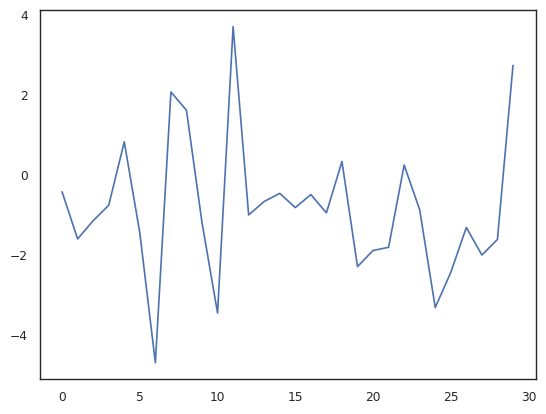

In [17]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
embeddings = df_verse['verse'].apply(lambda x: model.encode([x]))
embeddings = np.concatenate(embeddings, axis=0)

In [20]:
embeddings.shape

(107550, 384)

In [21]:
pca = PCA(n_components=1, random_state=42)
pca.fit(embeddings)

PCA(n_components=1, random_state=42)

In [22]:
joblib.dump(pca, '../models/gpca/sbert_pca.pkl')

['../models/gpca/sbert_pca.pkl']

In [23]:
pca = joblib.load('../models/gpca/sbert_pca.pkl')

["I wanna hold em' like they do in texas please", "Fold em' let em' hit me raise it", 'Baby stay with me', 'Lovegame intuition', 'Play the cards with spades to start', "And after he's been hooked", "I'll play the one that's on his heart", 'Oh, oh, oh, oh, ohhhh, ohh-oh-e-ohh-oh-oh', "I'll get him hot, show him what I've got", 'Oh, oh, oh, oh, ohhhh, ohh-oh-e-ohh-oh-oh', "I'll get him hot, show him what I've got", 'I wanna roll with him a hard pair we will be', "A little gambling is fun when you're with me", 'Russian roulette is not the same without a gun', "And baby when it's love if it's not rough it isn't fun, fun", 'Oh, oh, oh, oh, ohhhh, ohh-oh-e-ohh-oh-oh', "I'll get him hot, show him what I've got", 'Oh, oh, oh, oh, ohhhh, ohh-oh-e-ohh-oh-oh', "I'll get him hot, show him what I've got", "Can't read my", "Can't read my", "No he can't read my poker face", "Can't read my", "Can't read my", "No he can't read my poker face", "I wanna hold em' like they do in texas please", "Fold em' l

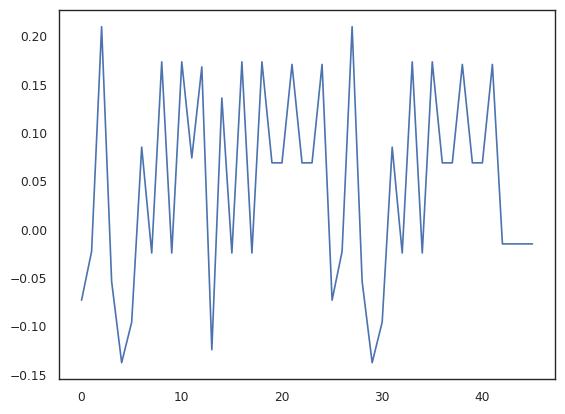

In [24]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = np.array([model.encode(verse) for verse in random_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [25]:
model = Doc2Vec.load("../models/d2v/doc2vec.model")

In [26]:
tokenized_verses = df_verse['verse'].apply(lambda x: list(tokenize(x, lowercase=True)))

In [27]:
embeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])

In [28]:
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(embeddings)

In [29]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_embeddings)

PCA(n_components=1, random_state=42)

In [30]:
joblib.dump(pca, '../models/gpca/d2v_pca.pkl')
joblib.dump(scaler, '../models/gpca/d2v_scaler.pkl')

['../models/gpca/d2v_scaler.pkl']

In [31]:
scaler = joblib.load('../models/gpca/d2v_scaler.pkl')
pca = joblib.load('../models/gpca/d2v_pca.pkl')

['Remember me? ', 'Remember me? ', 'Remember me? ', 'Remember me? ', "For this one it's the X, you retarded?", 'Cause I grab the mic and get Down, like Syndrome', 'Hide and roam into the masses, without boundaries', 'which qualifies me for the term "universal"', "Without no rehearsal, I leak words that's controversial", "Like I'm not, the one you wanna contest, see", "cause I'll hit yo' ass like the train did that bitch", 'that got "Banned From Tv" -- heavyweight hitter', 'Hit you watch your whole head split up', 'Loco-is-the-motion, we comin through', 'Hollow tips is the lead, the .45 threw', 'Remember me? ', 'Remember me? ', 'Remember me? ', 'Remember me? ', 'Niggaz that take no for an answer, get told no', 'Yeah I been told no but it was more like, "No, no, no!!!"', "Life a bitch that'll fuck you if you let her", 'Better come better than better to be a competitor', 'this vet is ahead of,', 'The shit is all redder, you deader and deader', 'A medic instead-a the cheddars and credda', 

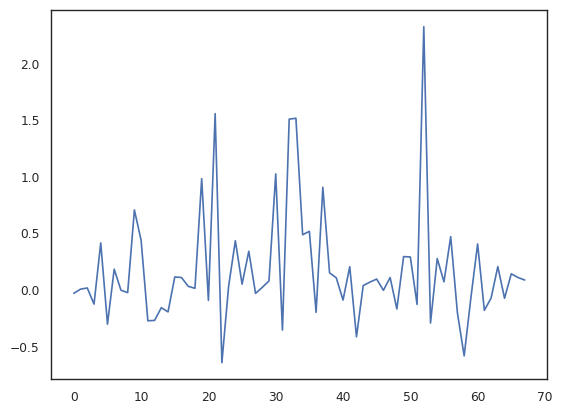

In [32]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = [list(tokenize(verse, lowercase=True)) for verse in random_lyrics]
    
eg_multi_ts = np.array([model.infer_vector(verse) for verse in tokenized_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [33]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [34]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [35]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [36]:
logits_tensor = df_verse['verse'].apply(get_logits, tokenizer=tokenizer, model=model)

In [37]:
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [38]:
tsne_model = TSNE(n_components=2, random_state=42, init='pca')

In [39]:
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels

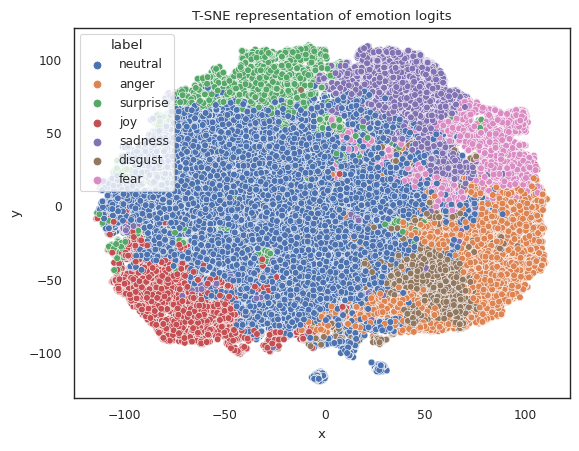

In [40]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
ax.set_title('T-SNE representation of emotion logits')
tikzplotlib.save('../tikz/tsne_emotions.tex')

In [41]:
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)

In [42]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_logits)

PCA(n_components=1, random_state=42)

In [43]:
joblib.dump(pca, '../models/gpca/emo_pca.pkl')
joblib.dump(scaler, '../models/gpca/emo_scaler.pkl')

['../models/gpca/emo_scaler.pkl']

In [44]:
scaler = joblib.load('../models/gpca/emo_scaler.pkl')
pca = joblib.load('../models/gpca/emo_pca.pkl')

['Put yo hood up! ', 'Put yo click up! ', "Represent yo' shit muthafuuuucka ", 'Represent yo click muthafuuuucka ', "Well shake yo' drink up and spray the muthafuckin' crowd ", "Throw yo' click up and say it muthafuckin' loud ", "Now drop yo' bows on em' and get buck ass wild ", "You supposed to act up with a black and fuckin' mild ", "Cuz' them eastside niggas don't give a fuck", 'Them westside niggas is quick to buck', 'Them northside niggas will cut you up', 'And them southside niggas will put you in a trunk', 'Now jump jump jump nigga', 'Stomp stomp stomp nigga', 'Jump jump jump nigga', 'Stomp stomp nigga', 'If you scared to throw it up get the fuck out the club ', "If you don't give a fuck then throw that muthafucka up ", "I'm wit my niggas in this bitch, and you know we fucked up ", 'We clicked up 30 deep and we always strapped up ', 'Who you wit nigga? Who you wit nigga?', 'Who you wit get crunk, who you wit nigga? ', 'Well who run this bitch? We run this bitch! ', 'Aye, check d

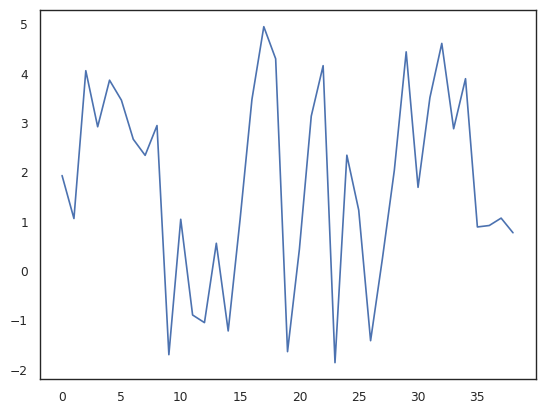

In [45]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)